# Lab Assignment 2 - Code

## Problem 1

### Imports

In [40]:
import time
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from keras.utils.np_utils import to_categorical
from tensorflow.keras import regularizers, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, Input

### Constants

In [41]:
RANDOM_STATE = 13

BATCH_NORMALIZATION = "BATCH_NORMALIZATION"
DROPOUT = "DROPOUT"
L2_REGULARIZATION = "L2_REGULARIZATION"

L2_COEFFICIENT = 0.00001
DROPOUT_RATE = 0.5

EPOCHS = 30
BATCH_SIZE = 64

### Import data and normalize

In [42]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()
dataset = np.concatenate((train_data, test_data))
categories = to_categorical(np.concatenate((train_labels, test_labels)), num_classes = 10)
dataset = dataset / 255

### Split data into train, validation and test datasets

In [43]:
x_train, x_val_test_combined, y_train, y_val_test_combined = train_test_split(dataset, categories, test_size = 0.3, random_state = RANDOM_STATE, stratify = categories)
x_validation, x_test, y_validation, y_test = train_test_split(x_val_test_combined, y_val_test_combined, test_size = 0.5, random_state = RANDOM_STATE, stratify = y_val_test_combined)
print("Training data:   ", x_train.shape, " -> ", y_train.shape)
print("Validation data: ", x_validation.shape, "  -> ", y_validation.shape)
print("Testing data:    ", x_test.shape, "  -> ", y_test.shape)

Training data:    (42000, 32, 32, 3)  ->  (42000, 10)
Validation data:  (9000, 32, 32, 3)   ->  (9000, 10)
Testing data:     (9000, 32, 32, 3)   ->  (9000, 10)


### Build models

Architecture 1
1.   No regularization
2.   Batch Normalization
3.   Dropout
4.   L2 regularization in layers

Architecture 2
1.   No regularization
2.   Batch Normalization
3.   Dropout
4.   L2 regularization in layers

In [44]:
regularizations = [None, BATCH_NORMALIZATION, DROPOUT, L2_REGULARIZATION]
layers = [(16, 16), (16, 16, 16, 16)]
models = {(layers[i], regularizations[j]): None for i in range(len(layers)) for j in range(len(regularizations))}

In [45]:
def build_model(filters, regularization, name):
    model = Sequential(name = name)
    model.add(Input(shape = (32, 32, 3)))
    for filter in filters:
        l2_regulizer = None
        if regularization == L2_REGULARIZATION:
            l2_regulizer = regularizers.l2(L2_COEFFICIENT)
        model.add(Conv2D(filter, kernel_size = 2, activation = 'relu', kernel_regularizer = l2_regulizer))
        model.add(MaxPooling2D(pool_size=(2,2)))
        if regularization == BATCH_NORMALIZATION:
            model.add(BatchNormalization())
        if regularization == DROPOUT:
            model.add(Dropout(DROPOUT_RATE))
    model.add(Flatten())
    model.add(Dense(100, activation = 'relu',kernel_regularizer=l2_regulizer))
    if regularization == BATCH_NORMALIZATION:
        model.add(BatchNormalization())
    if regularization == DROPOUT:
        model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(10, activation = "softmax"))
    model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return model

for key,i in zip(models.keys(), range(8)):
    models[key] = build_model(key[0], key[1], "Model_" + str(i+1))

In [46]:
def train_model(model):
    print("Starting training for", model.name)
    start = time.time()
    model.fit(x_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = (x_validation, y_validation))
    end = time.time()
    print("Completed training", model.name, "in", str(end - start) + "s")
    return model.name, (end - start, model.history.history["accuracy"], model.history.history["val_accuracy"])

### Train model

In [47]:
metrics = {}

for _, model in models.items():
    name, metric = train_model(model)
    metrics[name] = metric

Starting training for Model_1
Epoch 1/30
657/657 [==============================] - 5s 7ms/step - loss: 1.6712 - accuracy: 0.4018 - val_loss: 1.4169 - val_accuracy: 0.4983
Epoch 2/30
657/657 [==============================] - 5s 7ms/step - loss: 1.3436 - accuracy: 0.5257 - val_loss: 1.2653 - val_accuracy: 0.5532
Epoch 3/30
657/657 [==============================] - 4s 6ms/step - loss: 1.2347 - accuracy: 0.5673 - val_loss: 1.2471 - val_accuracy: 0.5531
Epoch 4/30
657/657 [==============================] - 5s 7ms/step - loss: 1.1602 - accuracy: 0.5935 - val_loss: 1.1871 - val_accuracy: 0.5821
Epoch 5/30
657/657 [==============================] - 4s 7ms/step - loss: 1.1010 - accuracy: 0.6150 - val_loss: 1.1475 - val_accuracy: 0.5962
Epoch 6/30
657/657 [==============================] - 4s 7ms/step - loss: 1.0490 - accuracy: 0.6355 - val_loss: 1.1083 - val_accuracy: 0.6108
Epoch 7/30
657/657 [==============================] - 4s 7ms/step - loss: 1.0097 - accuracy: 0.6481 - val_loss: 1.0812

### Calculate accuracy

In [48]:
total_training_time = 0
for name, metric in metrics.items():
    total_training_time += metric[0]
    print("Training time for", name, str(metric[0]) + "s")
print("Total training time:", str(total_training_time) + "s")

Training time for Model_1 135.59960007667542s
Training time for Model_2 153.57452011108398s
Training time for Model_3 134.63001489639282s
Training time for Model_4 114.7795922756195s
Training time for Model_5 133.4796359539032s
Training time for Model_6 160.071448802948s
Training time for Model_7 149.18186807632446s
Training time for Model_8 134.56025791168213s
Total training time: 1115.8769381046295s


### Plot graphs for accuracy vs number of epochs

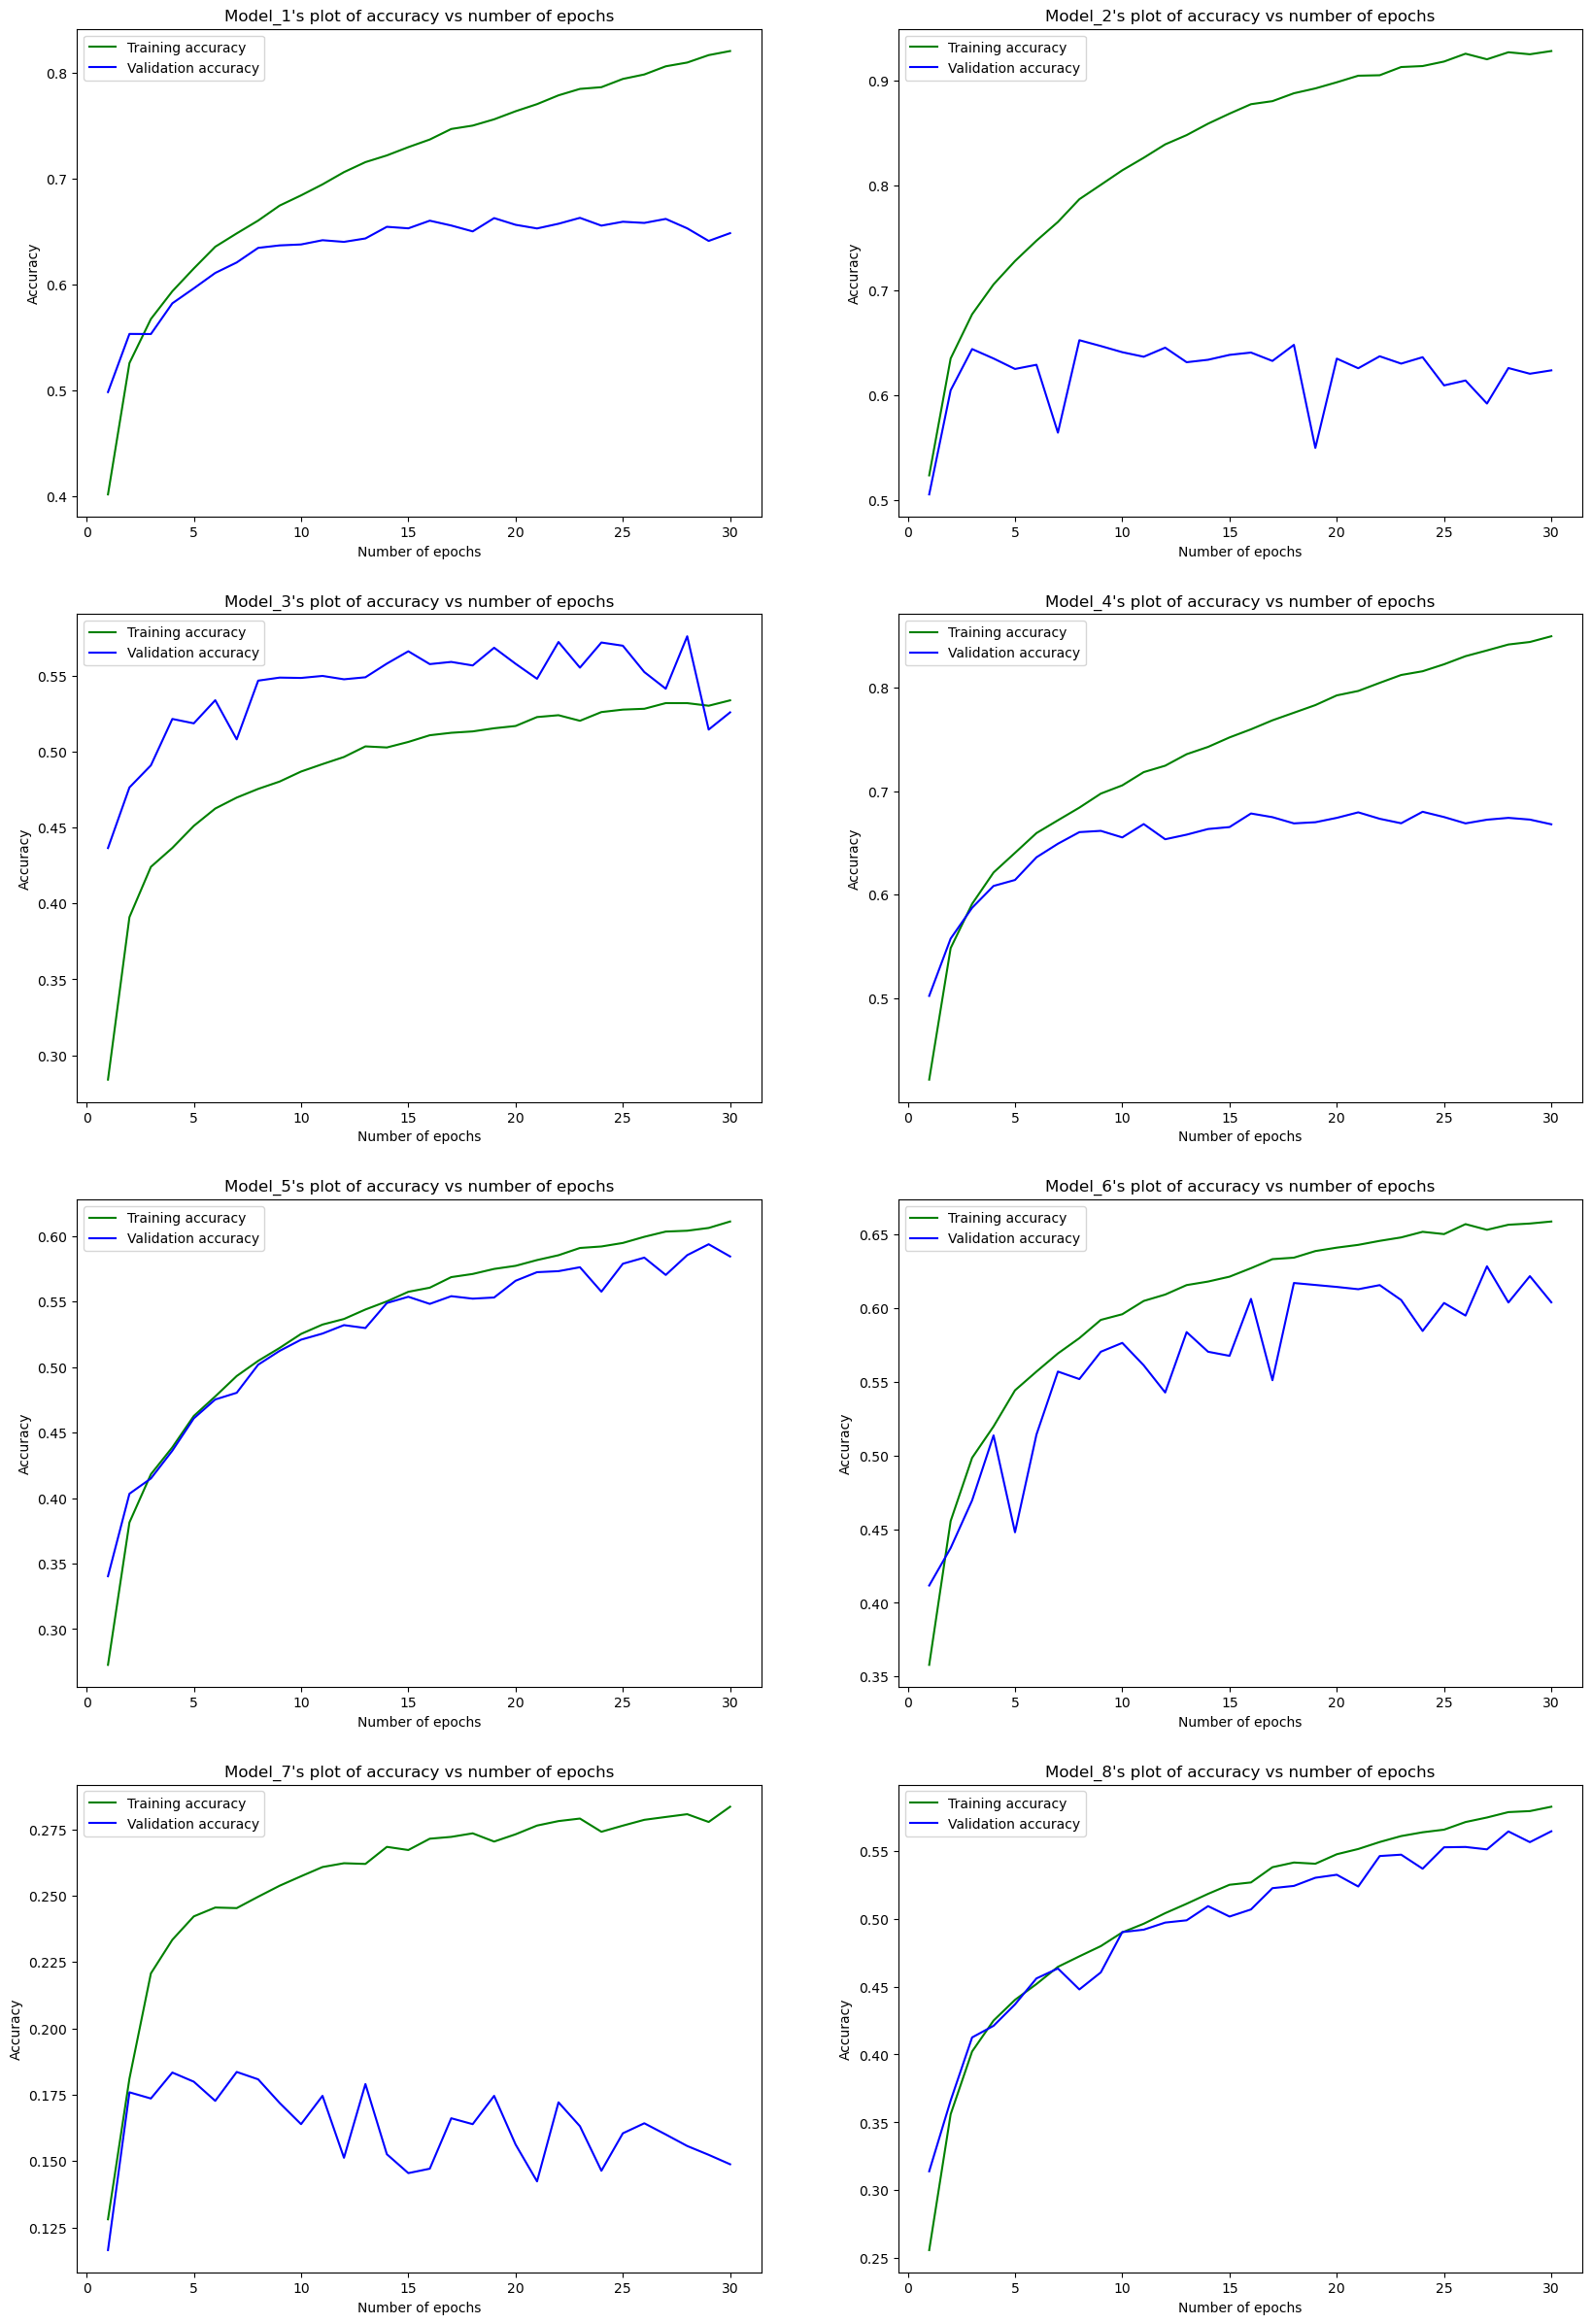

In [65]:
plt.subplots(4, 2, figsize=(20, 30))
for i, (name, metric) in enumerate(metrics.items()):
  plt.subplot(4,2,i+1)
  plt.plot([i for i in range(1,EPOCHS+1)], metric[1], color = "green", label = "Training accuracy")
  plt.plot([i for i in range(1,EPOCHS+1)],metric[2], color = "blue", label = "Validation accuracy")
  plt.title(name + "'s plot of accuracy vs number of epochs")
  plt.ylabel("Accuracy")
  plt.xlabel("Number of epochs")
  plt.legend()
plt.show()

### Find the top performing model

In [63]:
top_model_name = None
top_accuracy = 0
for name, metric in metrics.items():
    print(name, metric[0], metric[1][-1], metric[2][-1])
    if metric[2][-1] > top_accuracy:
        top_accuracy = metric[2][-1]
        top_model_name = name

top_model = None
top_model_params = None
for params, model in models.items():
    if model.name == top_model_name:
        top_model_params = params
        top_model = model
        break

print("Top performing model:", top_model_name)
print("Top performing model filters and regularization:", top_model_params)
print("Top performing model training accuracy:", metrics[top_model_name][1][-1])
print("Top performing model validation accuracy:", metrics[top_model_name][2][-1])
print("Top performing model time of training:", str(metrics[top_model_name][0]) + "s")

Model_1 135.59960007667542 0.8202381134033203 0.6483333110809326
Model_2 153.57452011108398 0.9285714030265808 0.6238889098167419
Model_3 134.63001489639282 0.5336904525756836 0.5257777571678162
Model_4 114.7795922756195 0.8497619032859802 0.6681110858917236
Model_5 133.4796359539032 0.6112619042396545 0.5845555663108826
Model_6 160.071448802948 0.6588571667671204 0.6039999723434448
Model_7 149.18186807632446 0.28347620368003845 0.1487777829170227
Model_8 134.56025791168213 0.5824047327041626 0.5643333196640015
Top performing model: Model_4
Top performing model filters and regularization: ((16, 16), 'L2')
Top performing model training accuracy: 0.8497619032859802
Top performing model validation accuracy: 0.6681110858917236
Top performing model time of training: 114.7795922756195s


### Train the top performing model with training + validation dataset

In [51]:
top_model = build_model(top_model_params[0], top_model_params[1], "top_performing_model")
x_train_validation_combined = np.concatenate((x_train, x_validation))
y_trail_validation_combined = np.concatenate((y_train, y_validation))
top_model.fit(x_train_validation_combined, y_trail_validation_combined, epochs = EPOCHS, batch_size = BATCH_SIZE)


Epoch 1/30
797/797 [==============================] - 5s 6ms/step - loss: 1.5919 - accuracy: 0.4293
Epoch 2/30
797/797 [==============================] - 4s 6ms/step - loss: 1.3063 - accuracy: 0.5371
Epoch 3/30
797/797 [==============================] - 4s 5ms/step - loss: 1.1797 - accuracy: 0.5871
Epoch 4/30
797/797 [==============================] - 4s 6ms/step - loss: 1.0981 - accuracy: 0.6166
Epoch 5/30
797/797 [==============================] - 5s 6ms/step - loss: 1.0405 - accuracy: 0.6359
Epoch 6/30
797/797 [==============================] - 4s 5ms/step - loss: 0.9920 - accuracy: 0.6540
Epoch 7/30
797/797 [==============================] - 4s 5ms/step - loss: 0.9475 - accuracy: 0.6685
Epoch 8/30
797/797 [==============================] - 4s 5ms/step - loss: 0.9142 - accuracy: 0.6828
Epoch 9/30
797/797 [==============================] - 4s 5ms/step - loss: 0.8806 - accuracy: 0.6932
Epoch 10/30
797/797 [==============================] - 4s 6ms/step - loss: 0.8546 - accuracy: 0.7046

### Calculate accuracy for the top performing model after re-training

In [52]:
training_accuracy = top_model.evaluate(x_train_validation_combined, y_trail_validation_combined)
test_accuracy = top_model.evaluate(x_test, y_test)
print("Training accuracy for top performing model after re-training:", training_accuracy[1])
print("Testing accuracy for top performing model after re-training:", test_accuracy[1])

282/282 [==============================] - 0s 1ms/step - loss: 1.1570 - accuracy: 0.6693
Training accuracy for top performing model after re-training: 0.856333315372467
Testing accuracy for top performing model after re-training: 0.6693333387374878


## Problem 2

### Create feature maps for each convolutional layer

In [67]:
layers = []
for i, layer in enumerate(top_model.layers):
    if layer.name.startswith('conv2d'):
        layers.append(layer)

visualizations = []
for layer in layers:
    layer_model = Model(inputs = top_model.inputs, outputs = layer.output)
    visualizations.append(layer_model.predict(dataset[6:7]))

1/1 [==============================] - 0s 33ms/step


### Visualize the convolutional filter

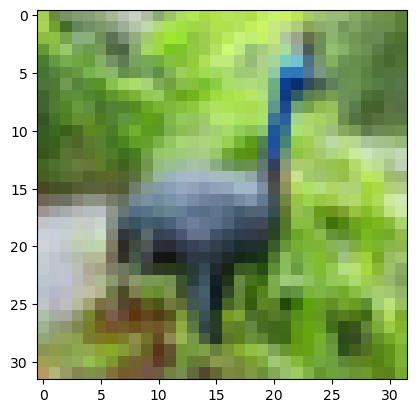

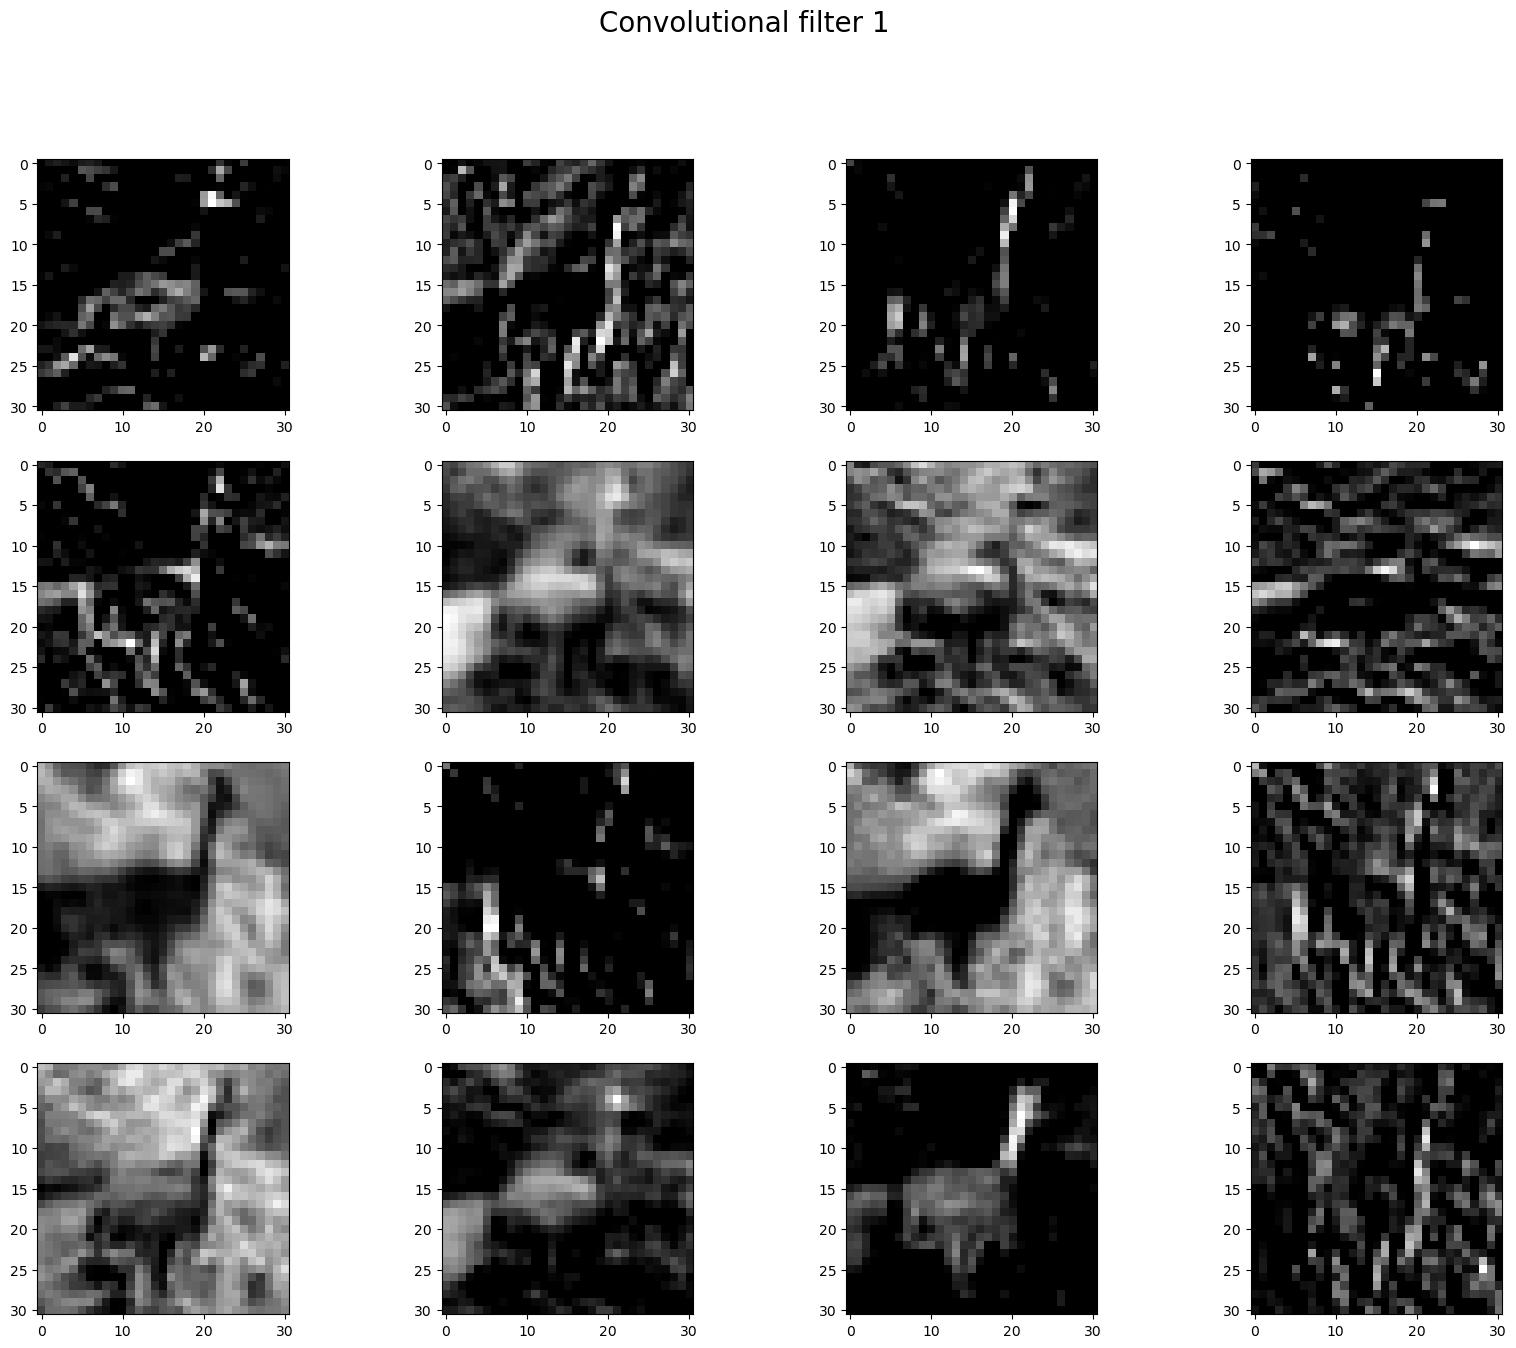

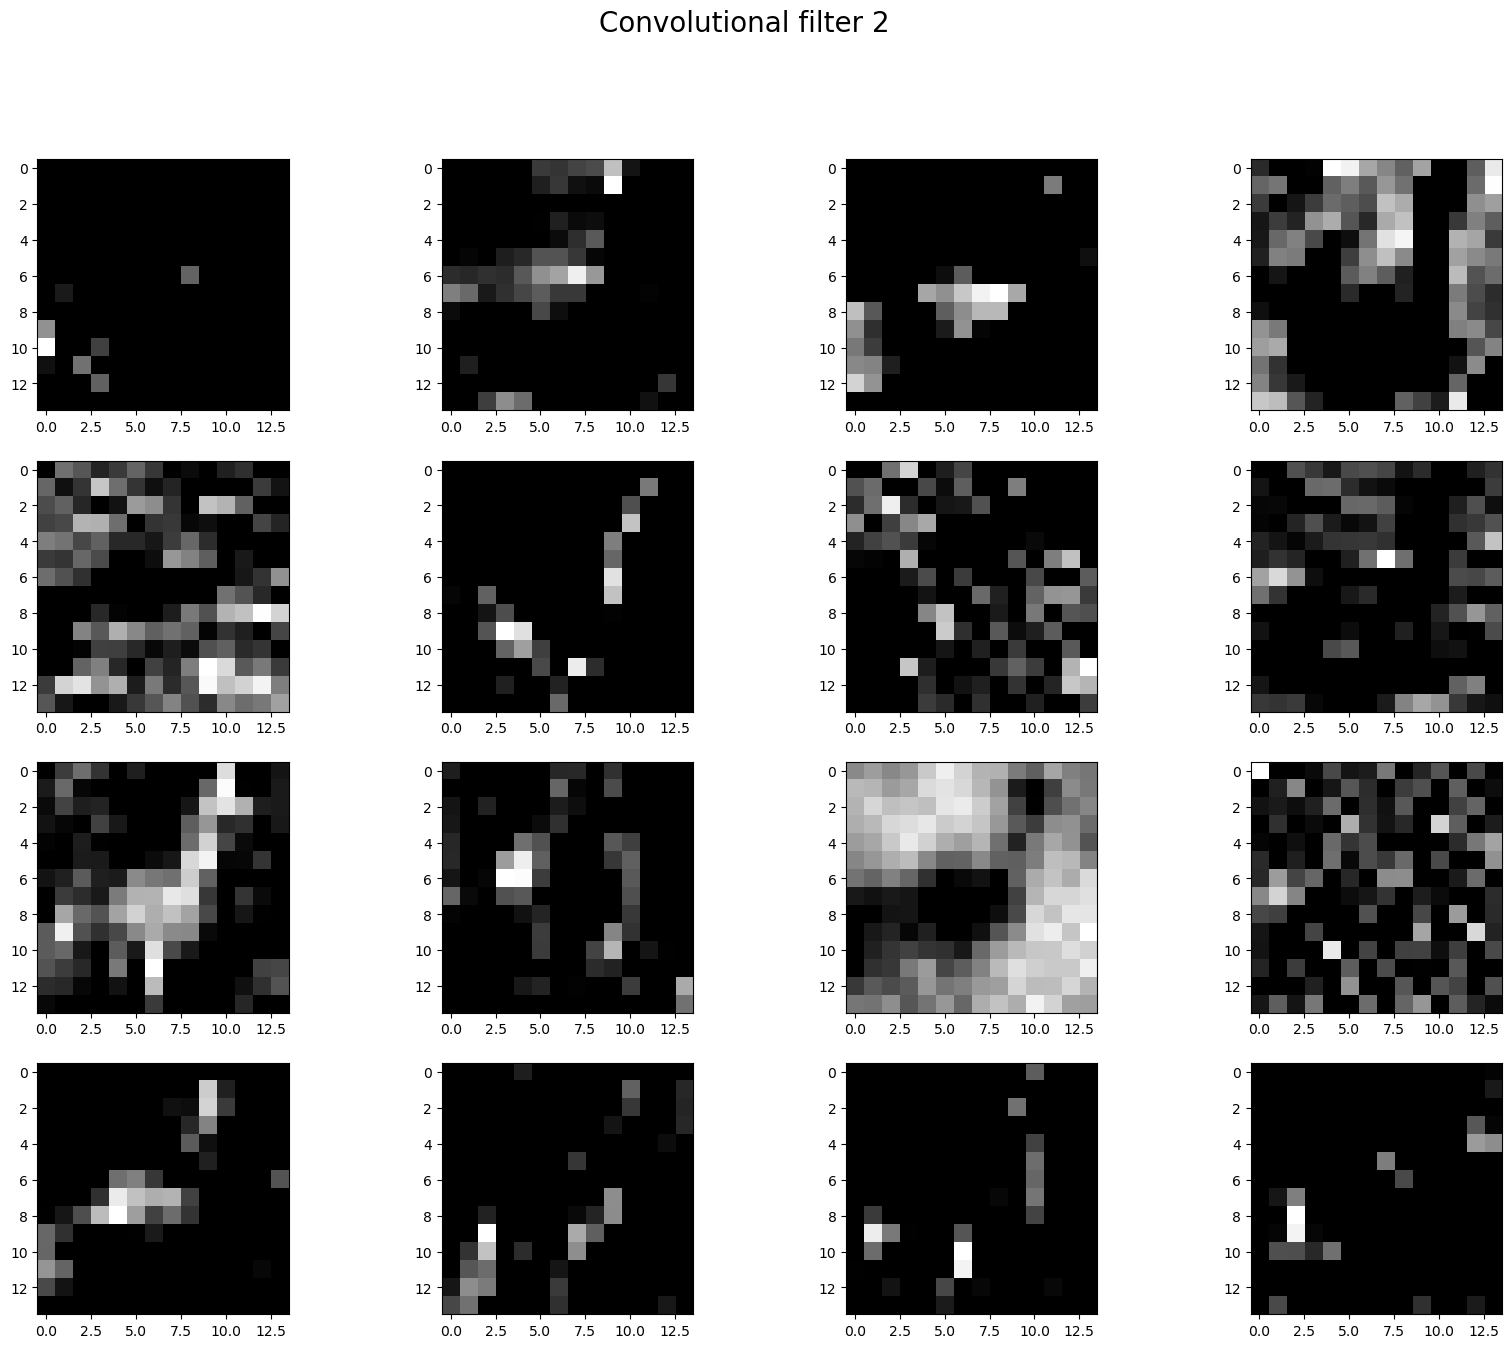

In [68]:
plt.imshow(dataset[6], cmap = 'gray')
for i in range(len(visualizations)):
  fig = plt.figure(figsize=(20,15))
  fig.suptitle("Convolutional filter " + str(i + 1) , fontsize=20)
  for j in range(visualizations[i].shape[3]):
      plt.subplot(4,4,j+1)
      plt.imshow(visualizations[i][0,:,:,j] , cmap='gray')
  plt.show()